In [219]:
#pip install sklearn

In [220]:
#pip install statsmodels

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, datetime, DataFrame, concat
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from numpy import asarray
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso

/var/folders/qx/45qd06nx2qd2trddy7cztt5h0000gn/T/ipykernel_17760/1093792613.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import read_csv, datetime, DataFrame, concat


In [222]:
df_cases = pd.read_csv("Cases.csv", encoding= 'unicode_escape')
df_deaths = pd.read_csv("Deaths.csv", encoding= 'unicode_escape')

In [223]:
# clean cases data and convert them to numeric
df_cases = df_cases.applymap(lambda x: x.strip())
df_cases = df_cases.applymap(lambda x: x.replace(",", ""))
df_cases = df_cases.applymap(lambda x: x.replace("..", ""))

counties = df_cases.columns[1:]
for county in counties:
    df_cases[county] = pd.to_numeric(df_cases[county],errors='coerce')

df_cases = df_cases.fillna(0)
df_deaths = df_deaths.fillna(0)

In [224]:
# display df test for all counties to detect if there are trends
def county_plots(counties, file_name=None):
    figure = plt.gcf()
    figure.set_size_inches(20, 20)
    figure.suptitle('County Trends (Dickey Fuller Test)', fontsize=18)
    plt.rcParams['figure.constrained_layout.use'] = False

    for idx, county in enumerate(counties):
        result = adfuller(df_cases[county].dropna())
        ax = figure.add_subplot(8, 4, idx+1)
        plt.title("County " + county + (' (p-value: %.3f)' % result[1]), fontsize=13)
        plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
        ax.set_xlabel('Week'); ax.set_ylabel('cases')
        df_cases[county].plot(ax=ax)
    
    if file_name:
        plt.savefig(file_name, dpi=300, bbox_inches="tight")
    plt.show()

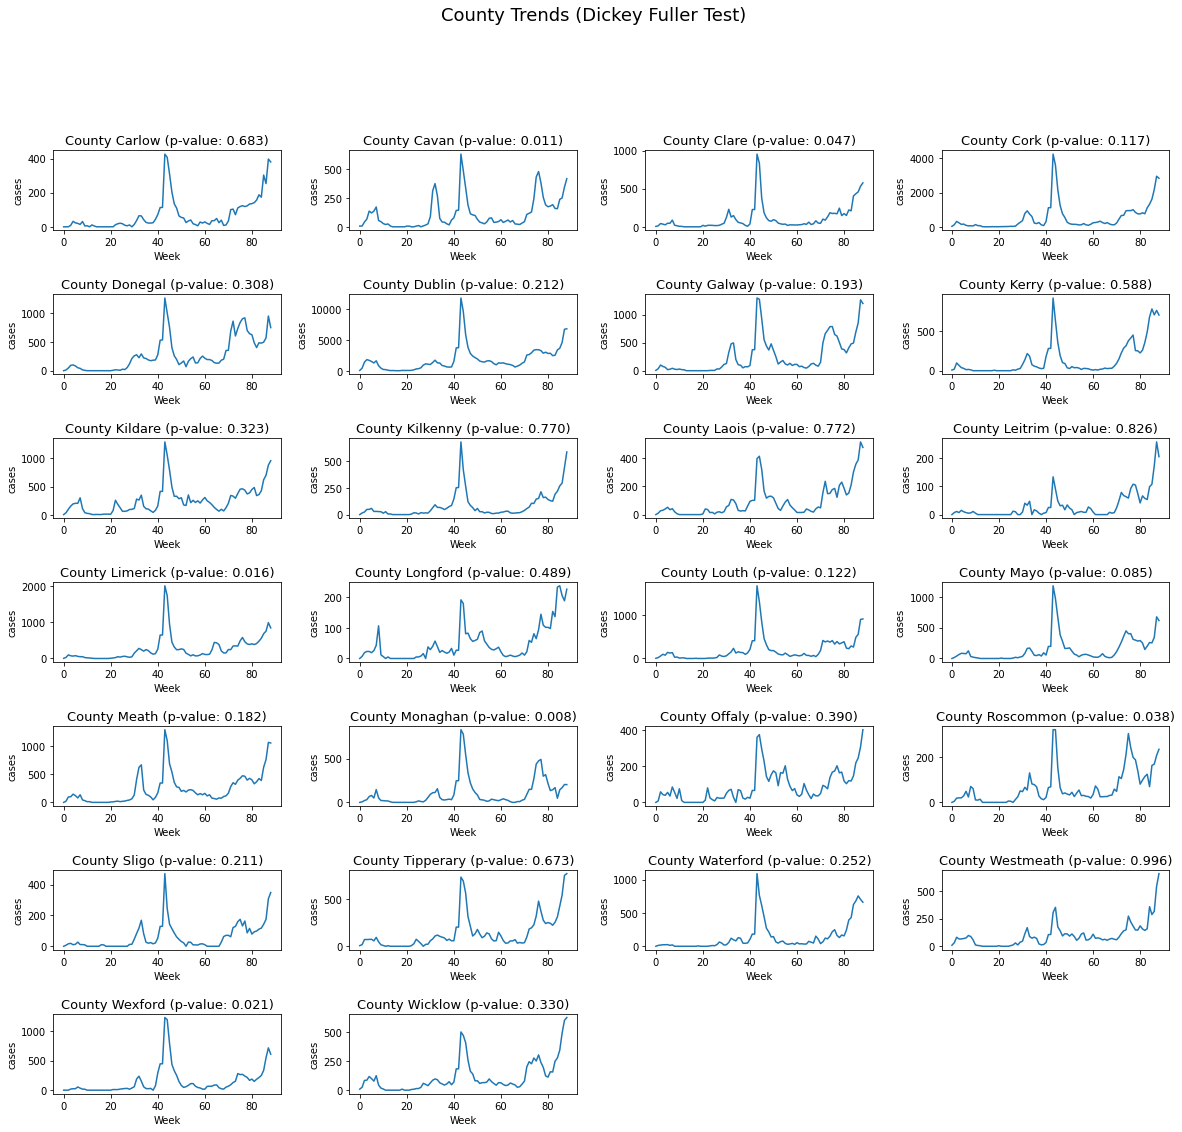

In [225]:
county_plots(counties, file_name='all_counties_without_diff')

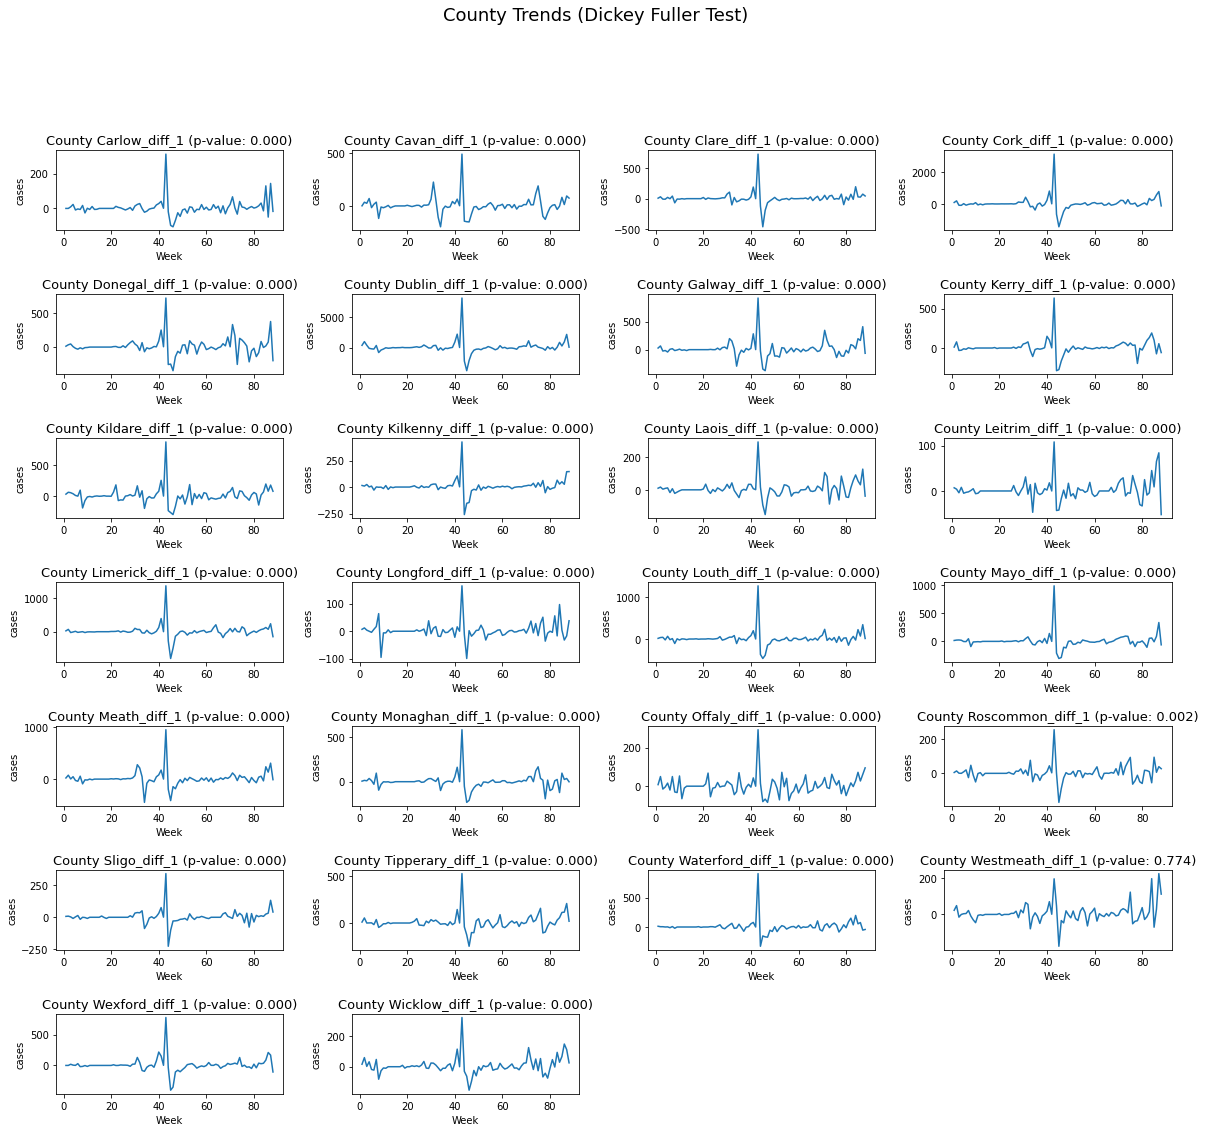

In [226]:
# remove trends by differencing
new_cols = []
for county in counties:
    new_cols.append(county + "_diff_1")
    df_cases[county + "_diff_1"] = df_cases[county].diff(periods=1)

county_plots(new_cols, 'counties_after_diff_1')

# 1st differenced ordered counties
counties_order_1 = [county for county in new_cols if county != 'Westmeath_diff_1']

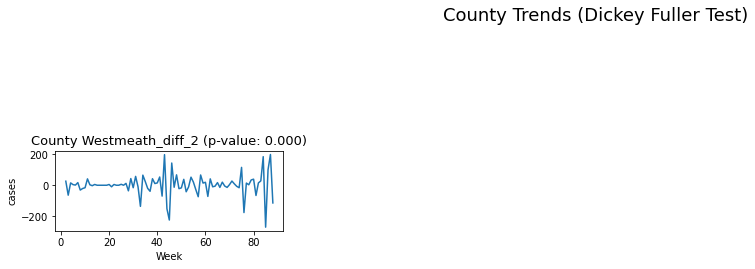

In [227]:

# since westmeath was not stationary after 1st differencing, we have introduced 2nd order difference
df_cases["Westmeath_diff_2"] = df_cases["Westmeath_diff_1"].diff(periods=1)
county_plots(["Westmeath_diff_2"], 'Westmeath_diff_2')

counties_order_2 = ['Westmeath_diff_2']

In [228]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = DataFrame(data)
    
    cols = list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))

    for i in range(0, n_out):
        cols.append(df.shift(-i))

    agg = concat(cols, axis=1)

    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX, n_estimators=1000):
    train = asarray(train)
    
    trainX, trainy = train[:, :-1], train[:, -1]
    
    model = RandomForestRegressor(n_estimators=n_estimators)
    model.fit(trainX, trainy)

    yhat = model.predict([testX])
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, n_est):
    predictions = list()

    train, test = train_test_split(data, n_test)

    history = [x for x in train]
    
    for i in range(len(test)):
        testX, testy = test[i, :-1], test[i, -1]
        
        yhat = random_forest_forecast(history, testX, n_est)
        
        predictions.append(yhat)
        
        history.append(test[i])

    
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    rmse = mean_squared_error(test[:, -1], predictions,squared=False)
    return error,rmse, test[:, -1], predictions

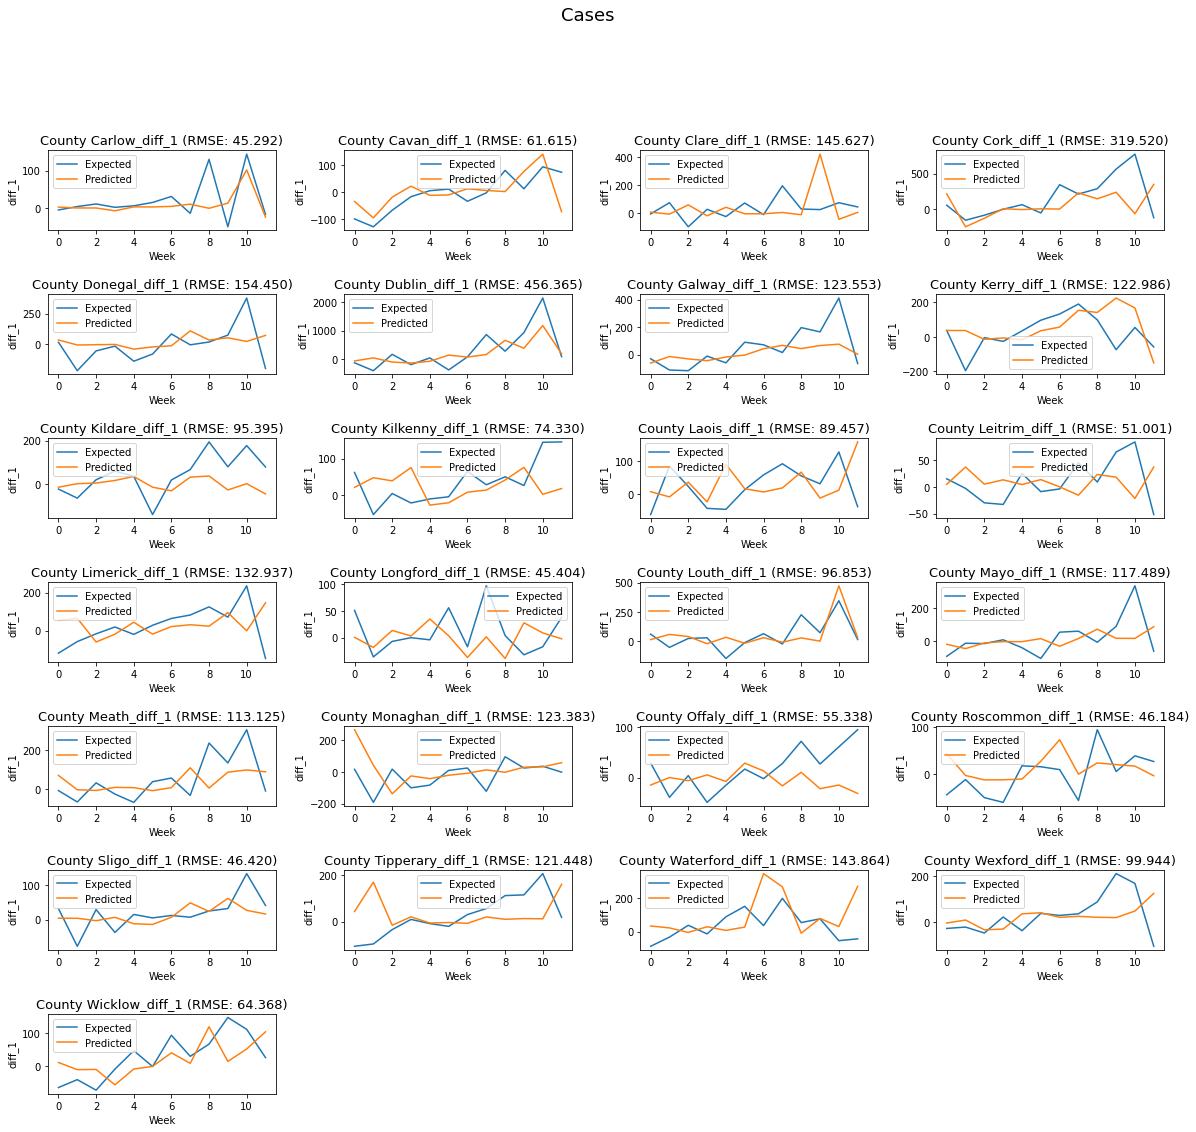

In [229]:
# all counties 1st order
weeks_test = 12
last_weeks_input = 8

figure = plt.gcf()
figure.set_size_inches(20, 20)
figure.suptitle('Cases', fontsize=18)
plt.rcParams['figure.constrained_layout.use'] = False

for idx, county in enumerate(counties_order_1):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)

    # evaluate
    mae,rmse, y, yhat = walk_forward_validation(data, weeks_test, n_est=2000)
    
    ax = figure.add_subplot(8, 4, idx+1)
    plt.title("County " + county + (' (RMSE: %.3f)' % rmse), fontsize=13)
    plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
    ax.plot(y, label='Expected')
    ax.plot(yhat, label='Predicted')
    ax.legend()
    ax.set_xlabel('Week'); ax.set_ylabel('diff_1')

plt.savefig('order_1_counties_eval', dpi=300, bbox_inches="tight")
pyplot.show()

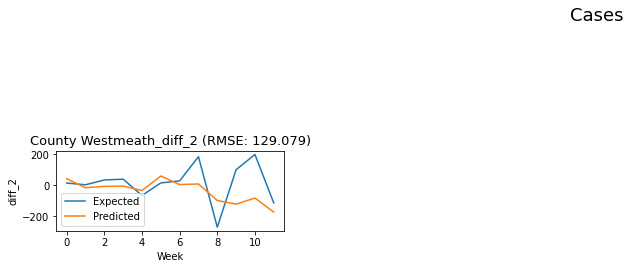

In [230]:
# all counties 2nd order
weeks_test = 12
last_weeks_input = 8

figure = plt.gcf()
figure.set_size_inches(20, 20)
figure.suptitle('Cases', fontsize=18)
plt.rcParams['figure.constrained_layout.use'] = False

for idx, county in enumerate(counties_order_2):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)

    # evaluate
    mae,rmse, y, yhat = walk_forward_validation(data, weeks_test, n_est=2000)
    
    ax = figure.add_subplot(8, 4, idx+1)
    plt.title("County " + county + (' (RMSE: %.3f)' % rmse), fontsize=13)
    plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
    ax.plot(y, label='Expected')
    ax.plot(yhat, label='Predicted')
    ax.legend()
    ax.set_xlabel('Week'); ax.set_ylabel('diff_2')

plt.savefig('order_2_county_eval', dpi=300, bbox_inches="tight")
pyplot.show()

In [231]:
# counties 1st order predictions
def future_predictions(county, weeks_ahead = 4):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)
    # split into input and output columns

    trainX, trainy = data[:, :-1], data[:, -1]

    # fit model
    model = RandomForestRegressor(n_estimators=2000)
    model.fit(trainX, trainy)


    # construct an input for a new prediction
    row = df_cases[[county]].values[-last_weeks_input:].flatten()
    last_cases = df_cases[county.split('_')[0]].values[-1:][0]

    prediction = []
    
    for i in range(weeks_ahead):
        yhat = model.predict(asarray([row]))

        
        # print('Input: %s, Predicted: %.3f' % (row, yhat[0] + last_cases))
        # invert
        
        prediction.append(round(yhat[0] + last_cases))
        
        row = np.append(row, round(yhat[0]))
        row = np.delete(row, 0)
        last_cases = yhat[0] + last_cases
    return prediction

In [232]:
# meath 2nd order predictions
def future_predictions_order_2(county, weeks_ahead = 4):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)
    
    # split into input and output columns
    trainX, trainy = data[:, :-1], data[:, -1]

    # fit model
    model = RandomForestRegressor(n_estimators=2000)
    model.fit(trainX, trainy)


    # construct an input for a new prediction
    row = df_cases[[county + '_diff_2']].values[-last_weeks_input:].flatten()
    last_cases = df_cases[county.split('_')[0]].values[-1:][0] + df_cases[county.split('_')[0] + '_diff_1'].values[-1:][0]

    prediction = []

    for i in range(weeks_ahead):
        yhat = model.predict(asarray([row]))

        prediction.append(round(yhat[0] + last_cases))
        row = np.append(row, round(yhat[0]))
        row = np.delete(row, 0)
        last_cases = yhat[0] + last_cases
    return prediction

In [233]:
county_pred = []

for county in counties_order_1:
    preds = future_predictions(county, 4)
    print('%s county : %s' % (county.split('_')[0], preds))
    county_pred.append((county, preds))
    
# handling 2nd order diff separately
county_pred.append(('Westmeath_diff', future_predictions_order_2("Westmeath")))

Carlow county : [429, 416, 464, 453]
Cavan county : [572, 578, 710, 684]
Clare county : [612, 649, 677, 690]
Cork county : [4268, 4115, 5340, 5230]
Donegal county : [890, 918, 993, 999]
Dublin county : [11092, 10917, 13053, 13092]
Galway county : [1375, 1357, 1284, 1211]
Kerry county : [616, 552, 510, 512]
Kildare county : [1028, 1009, 986, 968]
Kilkenny county : [791, 899, 990, 1068]
Laois county : [547, 597, 605, 609]
Leitrim county : [208, 207, 221, 246]
Limerick county : [807, 693, 647, 618]
Longford county : [241, 250, 261, 272]
Louth county : [1135, 1064, 1382, 1328]
Mayo county : [1101, 1069, 1554, 1470]
Meath county : [1178, 1079, 1073, 1071]
Monaghan county : [211, 214, 198, 185]
Offaly county : [385, 389, 383, 372]
Roscommon county : [273, 293, 306, 316]
Sligo county : [502, 458, 533, 485]
Tipperary county : [1002, 1017, 1210, 1185]
Waterford county : [721, 732, 732, 855]
Wexford county : [1029, 1050, 912, 942]
Wicklow county : [679, 697, 727, 691]


In [234]:
sorted_counties = sorted(county_pred, key=lambda x: x[1][1],reverse=True)

In [235]:
# 3 counties with largest cases for 4 weeks
for county in sorted_counties[:3]:
    print('%s county : %s' % (county[0].split('_')[0], county[1]))

Dublin county : [11092, 10917, 13053, 13092]
Cork county : [4268, 4115, 5340, 5230]
Galway county : [1375, 1357, 1284, 1211]


In [236]:
#Linear Regression

In [237]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit a linear regression model and make a one step prediction
def linear_regression_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = LinearRegression()
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = linear_regression_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    rmse = mean_squared_error(test[:, -1], predictions,squared=False)
    return error,rmse, test[:, -1], predictions

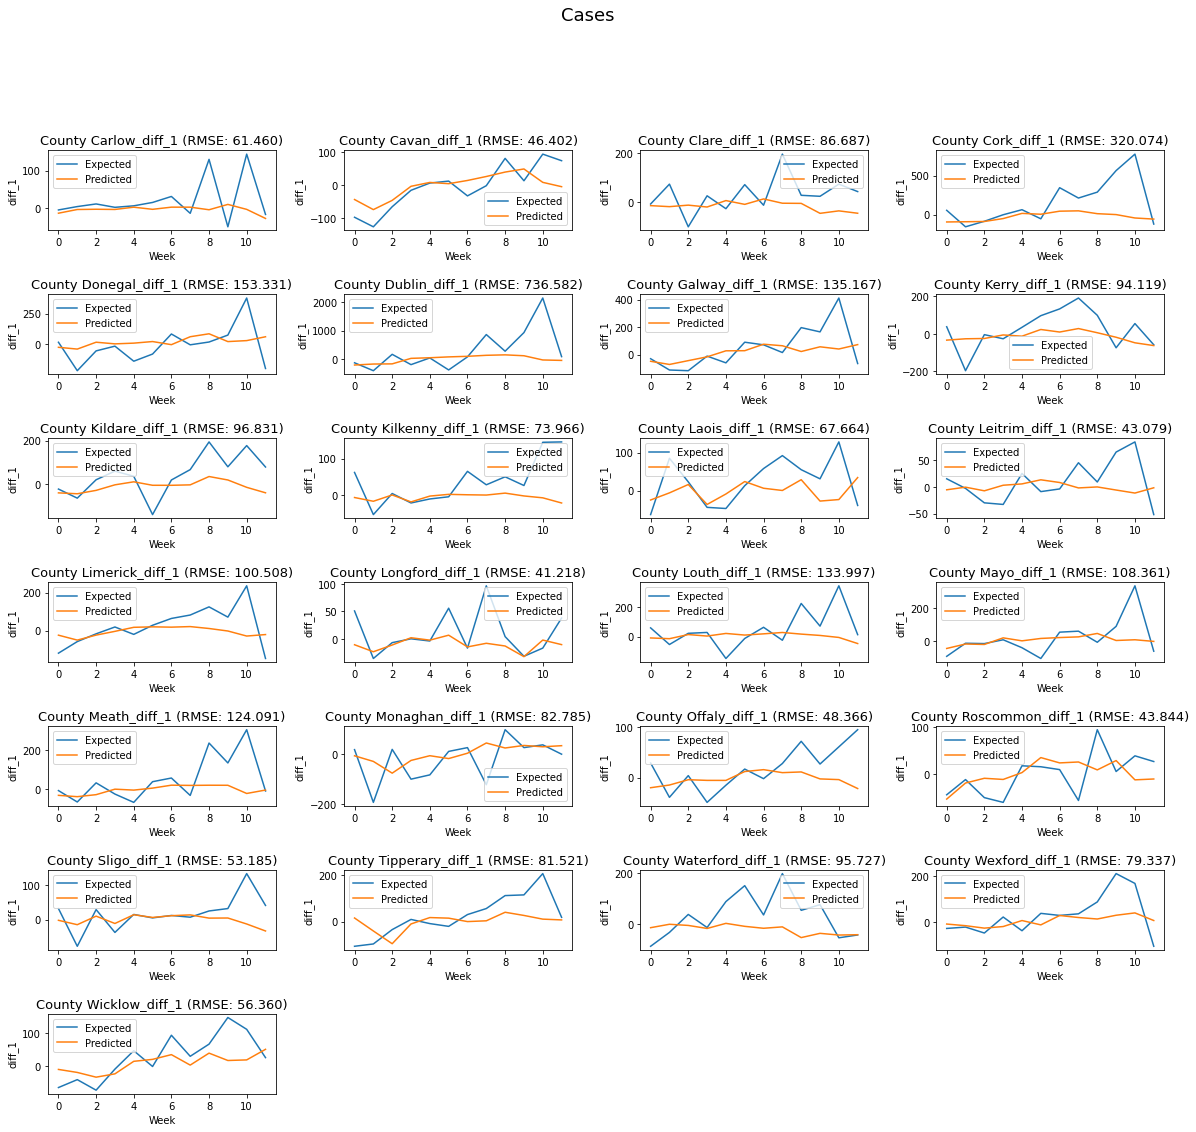

In [238]:
# all counties 1st order
weeks_test = 12
last_weeks_input = 8

figure = plt.gcf()
figure.set_size_inches(20, 20)
figure.suptitle('Cases', fontsize=18)
plt.rcParams['figure.constrained_layout.use'] = False

for idx, county in enumerate(counties_order_1):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)

    # evaluate
    mae,rmse, y, yhat = walk_forward_validation(data, weeks_test)
    
    ax = figure.add_subplot(8, 4, idx+1)
    #print(rmse)
    plt.title("County " + county + (' (RMSE: %.3f)' % rmse), fontsize=13)
    plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
    ax.plot(y, label='Expected')
    ax.plot(yhat, label='Predicted')
    ax.legend()
    ax.set_xlabel('Week'); ax.set_ylabel('diff_1')

plt.savefig('order_1_counties_eval', dpi=300, bbox_inches="tight")
pyplot.show()

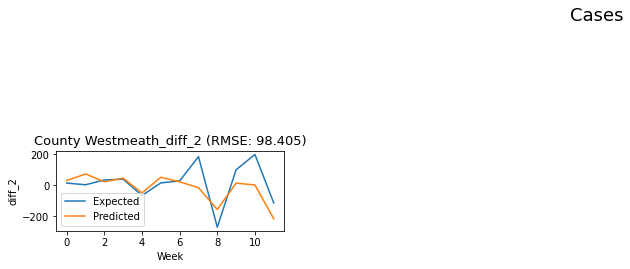

In [239]:
# all counties 2nd order
weeks_test = 12
last_weeks_input = 8

figure = plt.gcf()
figure.set_size_inches(20, 20)
figure.suptitle('Cases', fontsize=18)
plt.rcParams['figure.constrained_layout.use'] = False

for idx, county in enumerate(counties_order_2):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)

    # evaluate
    mae,rmse, y, yhat = walk_forward_validation(data, weeks_test)
    
    ax = figure.add_subplot(8, 4, idx+1)
    plt.title("County " + county + (' (RMSE: %.3f)' % rmse), fontsize=13)
    plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
    ax.plot(y, label='Expected')
    ax.plot(yhat, label='Predicted')
    ax.legend()
    ax.set_xlabel('Week'); ax.set_ylabel('diff_2')

plt.savefig('order_2_county_eval', dpi=300, bbox_inches="tight")
pyplot.show()

In [240]:
# counties 1st order predictions
def future_predictions(county, weeks_ahead = 4):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)
    # split into input and output columns

    trainX, trainy = data[:, :-1], data[:, -1]
    
    #normalising
    
    #trainX = np.arrange()

    # fit model
    model = LinearRegression()
    model.fit(trainX, trainy)


    # construct an input for a new prediction
    row = df_cases[[county]].values[-last_weeks_input:].flatten()
    last_cases = df_cases[county.split('_')[0]].values[-1:][0]

    prediction = []
    
    for i in range(weeks_ahead):
        yhat = model.predict(asarray([row]))

        
        # print('Input: %s, Predicted: %.3f' % (row, yhat[0] + last_cases))
        # invert
        prediction.append(round(yhat[0] + last_cases))
        
        row = np.append(row, round(yhat[0]))
        row = np.delete(row, 0)
        last_cases = yhat[0] + last_cases
    return prediction

In [241]:
# meath 2nd order predictions
def future_predictions_order_2(county, weeks_ahead = 4):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)
    
    # split into input and output columns
    trainX, trainy = data[:, :-1], data[:, -1]

    # fit model
    model = LinearRegression()
    model.fit(trainX, trainy)


    # construct an input for a new prediction
    row = df_cases[[county + '_diff_2']].values[-last_weeks_input:].flatten()
    last_cases = df_cases[county.split('_')[0]].values[-1:][0] + df_cases[county.split('_')[0] + '_diff_1'].values[-1:][0]

    prediction = []

    for i in range(weeks_ahead):
        yhat = model.predict(asarray([row]))

        prediction.append(round(yhat[0] + last_cases))

        row = np.append(row, round(yhat[0]))
        row = np.delete(row, 0)
        last_cases = yhat[0] + last_cases
    return prediction

In [242]:
county_pred = []

for county in counties_order_1:
    preds = future_predictions(county, 4)
    print('%s county : %s' % (county.split('_')[0], preds))
    county_pred.append((county, preds))
    
# handling 2nd order diff separately
county_pred.append(('Westmeath_diff', future_predictions_order_2("Westmeath")))

Carlow county : [400, 376, 363, 362]
Cavan county : [417, 383, 353, 332]
Clare county : [529, 488, 470, 448]
Cork county : [2631, 2392, 2135, 1991]
Donegal county : [777, 726, 715, 696]
Dublin county : [6617, 6257, 5772, 5428]
Galway county : [1149, 998, 936, 895]
Kerry county : [636, 602, 581, 607]
Kildare county : [927, 893, 818, 768]
Kilkenny county : [589, 582, 545, 521]
Laois county : [434, 407, 416, 395]
Leitrim county : [187, 174, 145, 147]
Limerick county : [765, 708, 690, 693]
Longford county : [230, 235, 230, 250]
Louth county : [885, 790, 737, 684]
Mayo county : [578, 521, 499, 441]
Meath county : [984, 902, 829, 764]
Monaghan county : [210, 196, 199, 196]
Offaly county : [387, 365, 336, 316]
Roscommon county : [228, 207, 189, 182]
Sligo county : [329, 312, 286, 266]
Tipperary county : [740, 655, 598, 548]
Waterford county : [637, 601, 605, 612]
Wexford county : [540, 518, 479, 415]
Wicklow county : [603, 543, 485, 446]


In [243]:
sorted_counties = sorted(county_pred, key=lambda x: x[1][1],reverse=True)

In [244]:
# 3 counties with largest cases for 4 weeks
for county in sorted_counties[:3]:
    print('%s county : %s' % (county[0].split('_')[0], county[1]))

Dublin county : [6617, 6257, 5772, 5428]
Cork county : [2631, 2392, 2135, 1991]
Galway county : [1149, 998, 936, 895]


In [ ]:
#Lasso Regression

In [257]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit a lasso regression model and make a one step prediction
def lasso_regression_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = Lasso(alpha = 0.01)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = lasso_regression_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    rmse = mean_squared_error(test[:, -1], predictions,squared=False)
    return error,rmse, test[:, -1], predictions

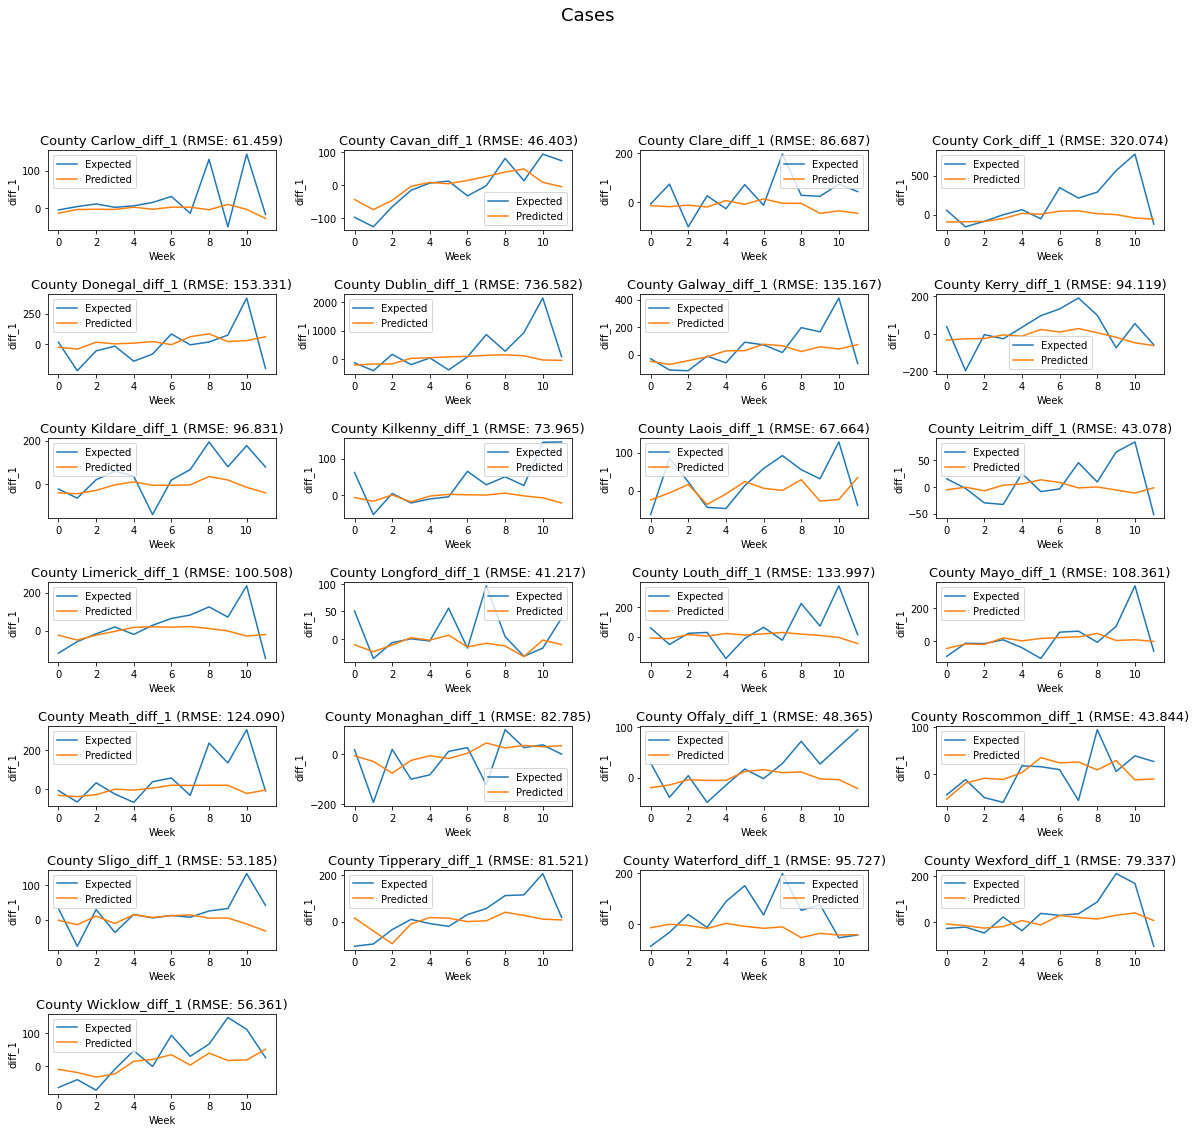

In [258]:
# all counties 1st order
weeks_test = 12
last_weeks_input = 8

figure = plt.gcf()
figure.set_size_inches(20, 20)
figure.suptitle('Cases', fontsize=18)
plt.rcParams['figure.constrained_layout.use'] = False

for idx, county in enumerate(counties_order_1):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)

    # evaluate
    mae,rmse, y, yhat = walk_forward_validation(data, weeks_test)
    
    ax = figure.add_subplot(8, 4, idx+1)
    #print(rmse)
    plt.title("County " + county + (' (RMSE: %.3f)' % rmse), fontsize=13)
    plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
    ax.plot(y, label='Expected')
    ax.plot(yhat, label='Predicted')
    ax.legend()
    ax.set_xlabel('Week'); ax.set_ylabel('diff_1')

plt.savefig('order_1_counties_eval', dpi=300, bbox_inches="tight")
pyplot.show()

Westmeath_diff_2  =  98.405


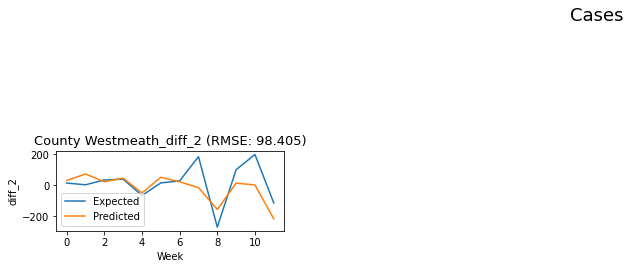

In [259]:
# all counties 2nd order
weeks_test = 12
last_weeks_input = 8

figure = plt.gcf()
figure.set_size_inches(20, 20)
figure.suptitle('Cases', fontsize=18)
plt.rcParams['figure.constrained_layout.use'] = False

for idx, county in enumerate(counties_order_2):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)

    # evaluate
    mae,rmse, y, yhat = walk_forward_validation(data, weeks_test)
    
    ax = figure.add_subplot(8, 4, idx+1)
    print(county ," = ", round(rmse,3))
    plt.title("County " + county + (' (RMSE: %.3f)' % rmse), fontsize=13)
    plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
    ax.plot(y, label='Expected')
    ax.plot(yhat, label='Predicted')
    ax.legend()
    ax.set_xlabel('Week'); ax.set_ylabel('diff_2')

plt.savefig('order_2_county_eval', dpi=300, bbox_inches="tight")
pyplot.show()

In [265]:
# counties 1st order predictions
def future_predictions(county, weeks_ahead = 4):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)
    # split into input and output columns

    trainX, trainy = data[:, :-1], data[:, -1]
    
    #normalising
    
    #trainX = np.arrange()

    # fit model
    model = Lasso(alpha = 0.1)
    model.fit(trainX, trainy)


    # construct an input for a new prediction
    row = df_cases[[county]].values[-last_weeks_input:].flatten()
    last_cases = df_cases[county.split('_')[0]].values[-1:][0]

    prediction = []
    
    for i in range(weeks_ahead):
        yhat = model.predict(asarray([row]))

        
        # print('Input: %s, Predicted: %.3f' % (row, yhat[0] + last_cases))
        # invert
        prediction.append(round(yhat[0] + last_cases))
        
        row = np.append(row, round(yhat[0]))
        row = np.delete(row, 0)
        last_cases = yhat[0] + last_cases
    return prediction

In [272]:
# meath 2nd order predictions
def future_predictions_order_2(county, weeks_ahead = 4):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)
    
    # split into input and output columns
    trainX, trainy = data[:, :-1], data[:, -1]

    # fit model
    model = Lasso(alpha = 0.001)
    model.fit(trainX, trainy)


    # construct an input for a new prediction
    row = df_cases[[county + '_diff_2']].values[-last_weeks_input:].flatten()
    last_cases = df_cases[county.split('_')[0]].values[-1:][0] + df_cases[county.split('_')[0] + '_diff_1'].values[-1:][0]

    prediction = []

    for i in range(weeks_ahead):
        yhat = model.predict(asarray([row]))

        prediction.append(round(yhat[0] + last_cases))

        row = np.append(row, round(yhat[0]))
        row = np.delete(row, 0)
        last_cases = yhat[0] + last_cases
    return prediction

In [269]:
county_pred = []

for county in counties_order_1:
    preds = future_predictions(county, 4)
    print('%s county : %s' % (county.split('_')[0], preds))
    county_pred.append((county, preds))
    
# handling 2nd order diff separately
county_pred.append(('Westmeath_diff', future_predictions_order_2("Westmeath")))

Carlow county : [400, 376, 363, 362]
Cavan county : [417, 383, 353, 332]
Clare county : [529, 488, 470, 448]
Cork county : [2631, 2392, 2135, 1991]
Donegal county : [777, 726, 715, 696]
Dublin county : [6617, 6257, 5772, 5428]
Galway county : [1149, 998, 936, 895]
Kerry county : [636, 602, 581, 607]
Kildare county : [927, 893, 818, 769]
Kilkenny county : [589, 582, 545, 521]
Laois county : [434, 407, 416, 395]
Leitrim county : [187, 174, 146, 148]
Limerick county : [765, 708, 690, 693]
Longford county : [230, 235, 230, 250]
Louth county : [885, 790, 737, 684]
Mayo county : [578, 521, 499, 441]
Meath county : [984, 902, 829, 764]
Monaghan county : [210, 196, 199, 196]
Offaly county : [387, 365, 336, 316]
Roscommon county : [228, 207, 189, 182]
Sligo county : [329, 312, 286, 267]
Tipperary county : [740, 655, 598, 548]
Waterford county : [637, 601, 605, 612]
Wexford county : [540, 518, 479, 415]
Wicklow county : [603, 543, 485, 446]


In [270]:
sorted_counties = sorted(county_pred, key=lambda x: x[1][1],reverse=True)

In [271]:
# 3 counties with largest cases for 4 weeks
for county in sorted_counties[:3]:
    print('%s county : %s' % (county[0].split('_')[0], county[1]))

Dublin county : [6617, 6257, 5772, 5428]
Cork county : [2631, 2392, 2135, 1991]
Galway county : [1149, 998, 936, 895]


In [245]:
#Dummy Regressor

In [246]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit a Dummy regressor model and make a one step prediction
def dummy_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = DummyRegressor(strategy = "mean")
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = dummy_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    rmse = mean_squared_error(test[:, -1], predictions,squared=False)
    return error,rmse, test[:, -1], predictions

Carlow_diff_1  =  58.547
Cavan_diff_1  =  67.344
Clare_diff_1  =  74.188
Cork_diff_1  =  311.1
Donegal_diff_1  =  153.708
Dublin_diff_1  =  735.858
Galway_diff_1  =  151.385
Kerry_diff_1  =  102.108
Kildare_diff_1  =  95.973
Kilkenny_diff_1  =  67.692
Laois_diff_1  =  63.365
Leitrim_diff_1  =  39.685
Limerick_diff_1  =  102.486
Longford_diff_1  =  40.471
Louth_diff_1  =  130.249
Mayo_diff_1  =  112.187
Meath_diff_1  =  121.467
Monaghan_diff_1  =  83.976
Offaly_diff_1  =  44.495
Roscommon_diff_1  =  43.859
Sligo_diff_1  =  49.837
Tipperary_diff_1  =  88.371
Waterford_diff_1  =  86.741
Wexford_diff_1  =  90.7
Wicklow_diff_1  =  70.56


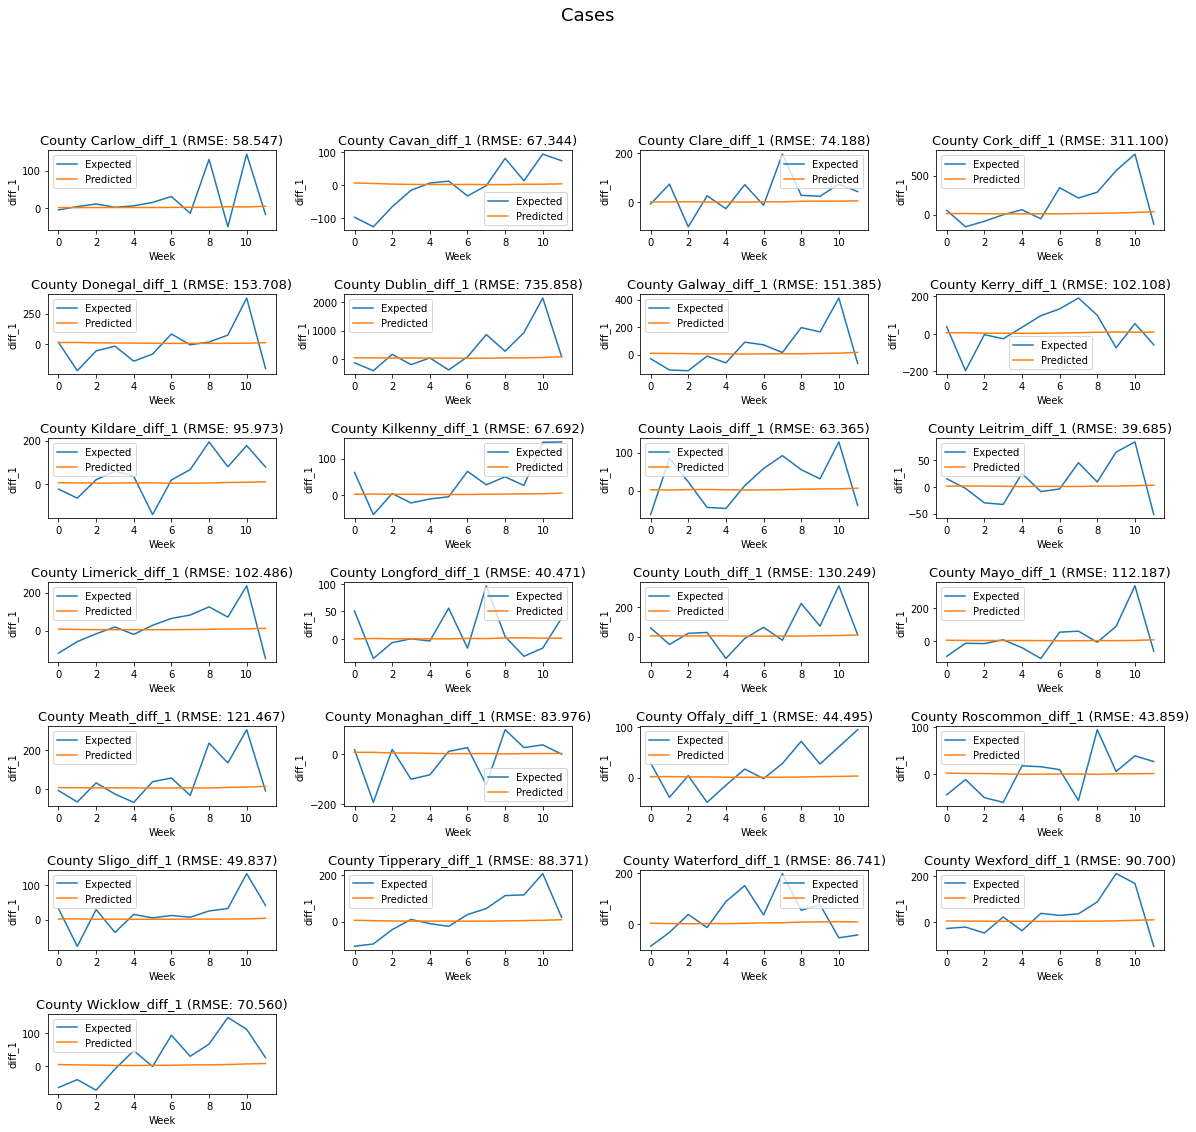

In [247]:
# all counties 1st order
weeks_test = 12
last_weeks_input = 8

figure = plt.gcf()
figure.set_size_inches(20, 20)
figure.suptitle('Cases', fontsize=18)
plt.rcParams['figure.constrained_layout.use'] = False

for idx, county in enumerate(counties_order_1):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)

    # evaluate
    mae,rmse, y, yhat = walk_forward_validation(data, weeks_test)
    
    ax = figure.add_subplot(8, 4, idx+1)
    print(county ," = ", round(rmse,3))
    plt.title("County " + county + (' (RMSE: %.3f)' % rmse), fontsize=13)
    plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
    ax.plot(y, label='Expected')
    ax.plot(yhat, label='Predicted')
    ax.legend()
    ax.set_xlabel('Week'); ax.set_ylabel('diff_1')

plt.savefig('order_1_counties_eval', dpi=300, bbox_inches="tight")
pyplot.show()

Westmeath_diff_2  =  122.237


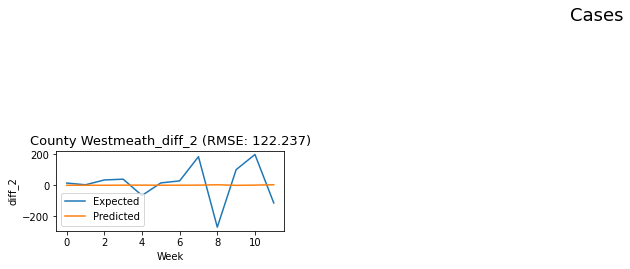

In [248]:
# all counties 2nd order
weeks_test = 12
last_weeks_input = 8

figure = plt.gcf()
figure.set_size_inches(20, 20)
figure.suptitle('Cases', fontsize=18)
plt.rcParams['figure.constrained_layout.use'] = False

for idx, county in enumerate(counties_order_2):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)

    # evaluate
    mae,rmse, y, yhat = walk_forward_validation(data, weeks_test)
    
    ax = figure.add_subplot(8, 4, idx+1)
    print(county ," = ", round(rmse,3))
    plt.title("County " + county + (' (RMSE: %.3f)' % rmse), fontsize=13)
    plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
    ax.plot(y, label='Expected')
    ax.plot(yhat, label='Predicted')
    ax.legend()
    ax.set_xlabel('Week'); ax.set_ylabel('diff_2')

plt.savefig('order_2_county_eval', dpi=300, bbox_inches="tight")
pyplot.show()

In [249]:
def future_predictions(county, weeks_ahead = 4):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)
    # split into input and output columns

    trainX, trainy = data[:, :-1], data[:, -1]
    
    #normalising
    
    #trainX = np.arrange()

    # fit model
    model = DummyRegressor(strategy="mean")
    model.fit(trainX, trainy)


    # construct an input for a new prediction
    row = df_cases[[county]].values[-last_weeks_input:].flatten()
    last_cases = df_cases[county.split('_')[0]].values[-1:][0]

    prediction = []
    
    for i in range(weeks_ahead):
        yhat = model.predict(asarray([row]))

        
        # print('Input: %s, Predicted: %.3f' % (row, yhat[0] + last_cases))
        # invert
        prediction.append(round(yhat[0] + last_cases))
        
        row = np.append(row, round(yhat[0]))
        row = np.delete(row, 0)
        last_cases = yhat[0] + last_cases
    return prediction

In [250]:
# meath 2nd order predictions
def future_predictions_order_2(county, weeks_ahead = 4):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)
    
    # split into input and output columns
    trainX, trainy = data[:, :-1], data[:, -1]

    # fit model
    model = DummyRegressor(strategy = "mean")
    model.fit(trainX, trainy)


    # construct an input for a new prediction
    row = df_cases[[county + '_diff_2']].values[-last_weeks_input:].flatten()
    last_cases = df_cases[county.split('_')[0]].values[-1:][0] + df_cases[county.split('_')[0] + '_diff_1'].values[-1:][0]

    prediction = []

    for i in range(weeks_ahead):
        yhat = model.predict(asarray([row]))

        prediction.append(round(yhat[0] + last_cases))

        row = np.append(row, round(yhat[0]))
        row = np.delete(row, 0)
        last_cases = yhat[0] + last_cases
    return prediction

In [251]:
county_pred = []

for county in counties_order_1:
    preds = future_predictions(county, 4)
    print('%s county : %s' % (county.split('_')[0], preds))
    county_pred.append((county, preds))
    
# handling 2nd order diff separately
county_pred.append(('Westmeath_diff', future_predictions_order_2("Westmeath")))

Carlow county : [385, 390, 394, 398]
Cavan county : [425, 429, 434, 438]
Clare county : [584, 591, 598, 605]
Cork county : [2868, 2902, 2937, 2972]
Donegal county : [756, 765, 774, 784]
Dublin county : [6931, 7006, 7081, 7157]
Galway county : [1216, 1230, 1245, 1260]
Kerry county : [711, 719, 728, 737]
Kildare county : [964, 974, 984, 995]
Kilkenny county : [592, 599, 606, 613]
Laois county : [484, 489, 495, 501]
Leitrim county : [206, 209, 211, 214]
Limerick county : [854, 864, 874, 884]
Longford county : [228, 230, 232, 233]
Louth county : [931, 942, 953, 965]
Mayo county : [622, 630, 637, 644]
Meath county : [1068, 1080, 1093, 1106]
Monaghan county : [205, 207, 209, 211]
Offaly county : [405, 410, 414, 418]
Roscommon county : [238, 240, 242, 244]
Sligo county : [353, 357, 362, 366]
Tipperary county : [775, 784, 793, 802]
Waterford county : [670, 679, 687, 695]
Wexford county : [614, 622, 629, 636]
Wicklow county : [635, 643, 650, 657]


In [252]:
sorted_counties = sorted(county_pred, key=lambda x: x[1][1],reverse=True)

In [253]:
# 3 counties with largest cases for 4 weeks
for county in sorted_counties[:3]:
    print('%s county : %s' % (county[0].split('_')[0], county[1]))

Dublin county : [6931, 7006, 7081, 7157]
Cork county : [2868, 2902, 2937, 2972]
Galway county : [1216, 1230, 1245, 1260]
